In [34]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import learning_curve
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
from tensorflow.keras.layers import Input, Flatten, Activation, RepeatVector
from tensorflow.keras.layers import Permute, multiply, Lambda, Dropout
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import LambdaCallback
from keras import backend as K


from tensorflow.keras import optimizers

import tensorflow as tf


np.set_printoptions(threshold=np.inf)

Using TensorFlow backend.


In [33]:
drugbank = pd.read_csv("adr_data_filtered_train.csv")
drugbank.iloc[1]

adrs       21, 04, 24, 17, 25, 07, 08, 09, 22, 23, 13, 12...
drug_id                                              DB01240
name                                            Epoprostenol
smile      [H][C@]12C[C@@H](O)[C@H](\C=C\[C@@H](O)CCCCC)[...
Name: 1, dtype: object

In [7]:
# testing the conversion from smile string to fingerprint
m1 = Chem.MolFromSmiles('COc1ccc(C(Nc2nc3c(ncn3COCC=O)c(=O)[nH]2)(c2ccccc2)c2ccccc2)cc1')
fp = AllChem.GetMorganFingerprintAsBitVect(m1,2,1024)
vector = np.array(fp)

In [15]:
drugbank.iloc[0][3]

'CCN1N=C(C(O)=O)C(=O)C2=CC3=C(OCO3)C=C12'

In [17]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# creating a new dataframe with vectors 1-1024 with target
finalTrainX = []
finalTrainY = []
targets = 27
for index, drug in drugbank.iterrows():
    try:
        # morgan fingerprints
        m1 = Chem.MolFromSmiles(drugbank.iloc[index, 3])
        fp = AllChem.GetMorganFingerprintAsBitVect(m1,2,1024)

        m2 = [0 for i in range(targets)]

        # checking if drug[10] is a string, adr parsing
        if isinstance(drug[0], str):
            split_values = drug[0].split(",")
            for i in range(len(split_values)):
                split_values[i] = split_values[i].strip()
            s = list(map(lambda x: int(x), split_values))
            for i in range(targets): 
                if i+1 in s:
                    m2[i] = 1
        finalTrainX.append(fp)
        finalTrainY.append(m2)
    except:
        pass
x_morgan = pd.DataFrame.from_records(finalTrainX)
y_morgan = pd.DataFrame.from_records(finalTrainY)

RDKit ERROR: [22:50:05] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [22:50:05] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [22:50:05] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [22:50:05] Explicit valence for atom # 0 N, 4, is greater than permitted


In [22]:
y_train = []
for index, row in y_morgan.iterrows():
    y_train.append(row.values)

In [25]:
X_train = []
for index, row in x_morgan.iterrows():
    X_train.append(row.values)
X_train

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

In [30]:
# Generate train main-validation split (80-20).
X_train_main, X_train_val, y_train_main, y_train_val = train_test_split(np.array(X_train), np.array(y_train), train_size=0.8, test_size=0.2)

In [37]:
adr_test = pd.read_csv("adr_data_filtered_test.csv")
adr_test.iloc[1]

adrs       21, 04, 24, 17, 25, 07, 08, 09, 22, 23, 13, 12...
drug_id                                              DB00712
name                                            Flurbiprofen
smile                  CC(C(O)=O)C1=CC(F)=C(C=C1)C1=CC=CC=C1
Name: 1, dtype: object

In [38]:
# creating a new dataframe with vectors 1-1024 with target

testX = []
testY = []
targets = 27
for index, drug in adr_test.iterrows():
    try:
        # morgan fingerprints
        m1 = Chem.MolFromSmiles(adr_test.iloc[index, 3])
        fp = AllChem.GetMorganFingerprintAsBitVect(m1,2,1024)

        m2 = [0 for i in range(targets)]

        # checking if drug[10] is a string, adr parsing
        if isinstance(drug[0], str):
            split_values = drug[0].split(",")
            for i in range(len(split_values)):
                split_values[i] = split_values[i].strip()
            s = list(map(lambda x: int(x), split_values))
            for i in range(targets): 
                if i+1 in s:
                    m2[i] = 1
        testX.append(fp)
        testY.append(m2)
    except:
        pass
x_morgan_test = pd.DataFrame.from_records(testX)
y_morgan_test = pd.DataFrame.from_records(testY)

In [66]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [54]:
y_test = []
for index, row in y_morgan_test.iterrows():
    y_test.append(row.values)
X_test = []
for index, row in x_morgan_test.iterrows():
    X_test.append(row.values)
    
X_test = np.array(X_test)
y_test = np.array(y_test)

In [67]:
# MLP
MLP_HIDDEN_SIZE = 64
NUM_ADR_CLASSES = 27
mlp = Sequential()
mlp.add(Input(shape=(1024,)))
mlp.add(Dense(MLP_HIDDEN_SIZE, activation='relu'))
mlp.add(Dropout(0.5))
mlp.add(Dense(MLP_HIDDEN_SIZE, activation='relu'))  # 'tanh'
mlp.add(Dropout(0.5))

mlp.add(Dense(NUM_ADR_CLASSES, activation='sigmoid'))

mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(mlp.summary())

mlp.fit(X_train, y_train,
# mlp.fit(X_train_main, y_train_main,
#                          validation_data=(X_train_val, y_train_val),
                         epochs=20, batch_size=64)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                65600     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 27)                1755      
Total params: 71,515
Trainable params: 71,515
Non-trainable params: 0
_________________________________________________________________
None
Train on 940 samples
Epoch 1/20
940/940 [==============================] - 1s 714us/sample - loss: 0.6735 - acc

In [68]:
mlp.evaluate(X_test, y_test)

237/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.46632866794046973, 0.7874668]

In [63]:
def plot_results(model, title="Results", val=False, mlp=False):
    start = 0
    if mlp:
        start = 1
    plt.plot(model.history.history['accuracy'][start:])
    if val:
        plt.plot(model.history.history['val_accuracy'][start:])
    plt.plot(model.history.history['loss'][start:])
    if val:
        plt.plot(model.history.history['val_loss'][start:])
    plt.title(title)
    if val:
        plt.legend(['train_acc', 'val_acc', 'train_loss', 'val_loss'], loc = 'best')
    else:
        plt.legend(['train_acc', 'train_loss'], loc = 'best')
    plt.xlabel('epoch')
    # plt.ylabel('accuracy')
    plt.show()

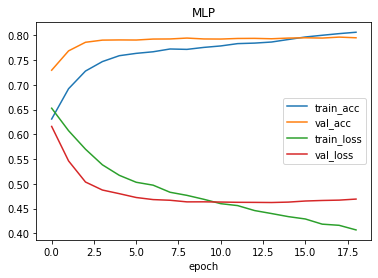

In [64]:
plot_results(mlp, title="MLP", mlp=True, val=True)

In [7]:
train_y

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,1,1,1,0,0,0,1,1,0,1,...,0,1,1,1,1,1,1,0,0,0
1,1,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,1,1,1,1,0,1,...,0,1,1,1,1,1,1,1,1,0
4,1,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10602,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10603,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10604,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10605,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [201]:
def errorPlot(y_pred, y_test, error_mean=False): 
    """plotting error terms, with histogram and kernel density estimator"""
    y_error = pd.DataFrame(y_pred-y_test)
    y_error = pd.Series(y_error.iloc[:, 2], name="z-axis error distance")
    if not error_mean:
        plt.figure()
        plt.ylabel("count")
        ax = sns.distplot(y_error)
    
    print("mean of z-error distance (meters): " + str(y_error.abs().mean()))
    print("variance in z-error distance: "+ str(y_error.var()))
    

def runmodel(trainX, trainY, plot=True, coef=False):
    '''runs model, using kfolds or regular train/test split, returns percentage correct prediction'''
    scaler = StandardScaler()
    scaler.fit(trainX)
    trainX = scaler.transform(trainX)
        
    # 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500
    train_sizes_abs, train_scores, test_scores = learning_curve(MLPClassifier(hidden_layer_sizes=(100, 20), max_iter=350, learning_rate="invscaling"), 
                                            trainX, trainY, cv=5, train_sizes=[1, 166, 333, 500, 1000, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8250])
    return train_sizes_abs, train_scores, test_scores

In [202]:
%%time
train_sizes_abs, train_scores, test_scores = runmodel(train_x, train_y)

/Users/dylanli/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:1360: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than the size of 'train_sizes' 20 instead of 21).
  % (train_sizes_abs.shape[0], n_ticks), RuntimeWarning)
/Users/dylanli/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/dylanli/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/dylanli/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

CPU times: user 52min 8s, sys: 1min 12s, total: 53min 21s
Wall time: 13min 32s


In [193]:
train_scores

array([[1.        , 0.99      , 0.992     , 0.99      , 0.992     ],
       [1.        , 0.983     , 0.983     , 0.981     , 0.984     ],
       [1.        , 0.976     , 0.978     , 0.98      , 0.978     ],
       [1.        , 0.9825    , 0.9795    , 0.9815    , 0.981     ],
       [1.        , 0.9824    , 0.9752    , 0.9812    , 0.9788    ],
       [0.99933333, 0.979     , 0.978     , 0.97666667, 0.98066667],
       [0.99885714, 0.97085714, 0.98457143, 0.96628571, 0.97342857],
       [0.99825   , 0.979     , 0.96625   , 0.98025   , 0.98025   ],
       [0.99377778, 0.98155556, 0.97644444, 0.98155556, 0.97955556],
       [0.998     , 0.946     , 0.9772    , 0.9484    , 0.976     ],
       [0.99327273, 0.96836364, 0.974     , 0.96872727, 0.972     ],
       [0.99483333, 0.96883333, 0.972     , 0.96716667, 0.933     ],
       [0.99307692, 0.96015385, 0.97661538, 0.97169231, 0.93276923],
       [0.99371429, 0.96928571, 0.97157143, 0.96771429, 0.97957143],
       [0.994     , 0.96373333, 0.

In [194]:
test_scores

array([[0.53157399, 0.24222432, 0.07543612, 0.07166431, 0.07732202],
       [0.56409048, 0.20829406, 0.08533711, 0.10749646, 0.12069778],
       [0.55419416, 0.31809614, 0.12682697, 0.14049976, 0.19330504],
       [0.56314797, 0.55513666, 0.27109854, 0.25271099, 0.29844413],
       [0.52120641, 0.6460886 , 0.35454974, 0.28005658, 0.31777463],
       [0.50801131, 0.67766258, 0.39368223, 0.3573786 , 0.40735502],
       [0.51083883, 0.65881244, 0.43564356, 0.427157  , 0.38330976],
       [0.51225259, 0.74740811, 0.49080622, 0.4582744 , 0.42668553],
       [0.51178134, 0.73185674, 0.49787836, 0.48892032, 0.48326261],
       [0.52403393, 0.76814326, 0.56765677, 0.52569543, 0.57944366],
       [0.5263902 , 0.80065975, 0.6077322 , 0.58085809, 0.56011315],
       [0.53440151, 0.79170594, 0.67656766, 0.60018859, 0.54078265],
       [0.53251649, 0.77097078, 0.69589816, 0.62847713, 0.62046205],
       [0.53204524, 0.82233742, 0.73455917, 0.66148043, 0.59405941],
       [0.55042413, 0.84542884, 0.

In [195]:
train_sizes_abs

array([ 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500,
       6000, 6500, 7000, 7500, 8000, 8250])

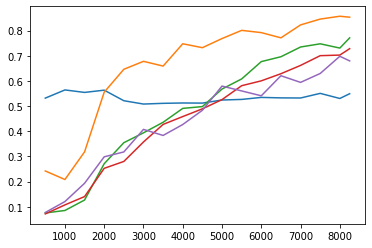

In [196]:
first_dim = []
for i in range(len(test_scores)):
    first_dim.append(test_scores[i])

plt.plot(train_sizes_abs, first_dim)
plt.xlabel('training samples')
plt.ylabel('training score')
plt.show()

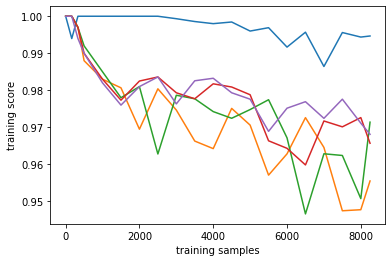

In [206]:
first_dim = []
for i in range(len(test_scores)):
    first_dim.append(train_scores[i])

plt.plot(train_sizes_abs, first_dim)
plt.xlabel('training samples')
plt.ylabel('training score')
plt.show()